In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

In [22]:
# train_data = pd.read_csv('D:\\DeepLearning\\DeepLearning\\train.csv')
# test_df = pd.read_csv('D:\\DeepLearning\\DeepLearning\\test.csv')
train_data = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [23]:
id =train_data.pop('id') #extract the id from the train data
y = train_data.pop('species') #extract the output values
y = LabelEncoder().fit(y).transform(y) # hot encoding the output labels

In [24]:
def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))

Load_image_data function ()


 -It initializes an output array X using NumPy with dimensions determined by the length of ids and the max_dim.


 -Loops through each image ID in the ids array.
 

 -Loads the image using load_img function from the specified directory (root) with the given image ID and .jpg extension, converting it to grayscale.

 -Resizes the loaded image using resize_img function while maintaining its aspect ratio to fit within the max_dim specified.

 -Converts the image to a NumPy array.

 -Inserts the resized and positioned image into the output array X.

In [25]:
# root = 'D:\\DeepLearning\\DeepLearning'
root='.'

def load_image_data(ids, max_dim=96, center=True):
   
    # Initialize the output array
    
    X = np.empty((len(ids), max_dim, max_dim, 1))

    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
       
        length = x.shape[0]
        width = x.shape[1]
       
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)

        # Insert into image matrix
       
        X[i, h1:h2, w1:w2, 0:1] = x
        
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)

 Load_train_data( )
    -Loads image training data and

    -splits them into training and cross-validation.

    -Returns one tuple for the training data and one for the validation data. 
    
    -Each tuple is in the orderimages,and labels.
    

In [26]:
def load_train_data(split=0.9, random_state=None):
   
    # Load the image data
    X_img_tr = load_image_data(id)
    
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    for train_ind, test_ind in sss.split(X_img_tr, y):
        X_img_val, y_val = X_img_tr[test_ind], y[test_ind]
        X_img_tr, y_tr = X_img_tr[train_ind], y[train_ind]
    
    return (X_img_tr, y_tr), (X_img_val, y_val)

load_test_data( )    
    -Loads the pre-extracted feature and image test data.
    
    -Returns a tuple in the order ids, pre-extracted features,
    and images.
    

In [27]:
def load_test_data():
   
    # Load the image data
    X_img_te = load_image_data(id)
    return id, X_img_te

In [45]:
# Load train and test data
(X_img_tr, y_tr), (X_img_val, y_val) = load_train_data(random_state=7)
id_test, X_img_te = load_test_data()

# Convert labels to categorical if needed
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)

print('Training data loaded!')


c:\Python311\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
c:\Python311\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Training data loaded!


Data Augmentation can be a good enhancement in the training stage

In [29]:
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

print('Creating Data Augmenter...')
imgen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
imgen_train = imgen.flow(X_img_tr, y_tr_cat, seed=np.random.randint(1, 10000))
print('Finished making data augmenter...')

Creating Data Augmenter...
Finished making data augmenter...


In [30]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input

def leaf_classification_model():
    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Conv2D(8, (5, 5), input_shape=(96, 96, 1), padding='same')(image)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Now through the second convolutional layer
    x = Conv2D(32, (5, 5), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Flatten our array
    x = Flatten()(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=image, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

model =leaf_classification_model()

# Trying ADAM, SGD, RMSProp Optimizers

In [37]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D




optimizers = ['sgd', 'adam', 'rmsprop']

for optimizer_name in optimizers:
    # Clear previous model sessions to avoid conflicts
    # keras.backend.clear_session()
    K.clear_session()
    
    # Create a new model
    model = leaf_classification_model()

    # Compile the model with the current optimizer
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

    # Display the current optimizer
    print(f"\nTraining with optimizer: {optimizer_name}")

    # Fit the model to your training data (adjust X_train_resized and y_categorical accordingly)
    history = model.fit(X_img_tr, y_tr_cat, epochs=40, validation_split=0.1, verbose=1)

    # Evaluate the model on your test data (adjust X_test_filtered_resized and y_test_categorical accordingly)
    test_loss, test_accuracy = model.evaluate(X_img_val, y_val_cat)
    print(f"Test Accuracy with {optimizer_name}: {test_accuracy}")


Training with optimizer: sgd
Epoch 1/40
26/26 [==============================] - 2s 40ms/step - loss: 4.5821 - accuracy: 0.0200 - val_loss: 4.5586 - val_accuracy: 0.0222
Epoch 2/40
26/26 [==============================] - 1s 27ms/step - loss: 4.5413 - accuracy: 0.0187 - val_loss: 4.5488 - val_accuracy: 0.0222
Epoch 3/40
26/26 [==============================] - 1s 28ms/step - loss: 4.5213 - accuracy: 0.0287 - val_loss: 4.5260 - val_accuracy: 0.0333
Epoch 4/40
26/26 [==============================] - 1s 27ms/step - loss: 4.4634 - accuracy: 0.0312 - val_loss: 4.3991 - val_accuracy: 0.0222
Epoch 5/40
26/26 [==============================] - 1s 26ms/step - loss: 4.3932 - accuracy: 0.0424 - val_loss: 4.6437 - val_accuracy: 0.0111
Epoch 6/40
26/26 [==============================] - 1s 26ms/step - loss: 4.3805 - accuracy: 0.0412 - val_loss: 4.5360 - val_accuracy: 0.0556
Epoch 7/40
26/26 [==============================] - 1s 26ms/step - loss: 4.3013 - accuracy: 0.0537 - val_loss: 4.2697 - val_

In [48]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import backend as K

# # # Define your model creation function (you can use your existing model creation logic)
def create_model(optimizer):
     model=leaf_classification_model()
     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
     return model

optimizers = ['sgd', 'adam', 'rmsprop']

for optimizer_name in optimizers:
    # Clear previous model sessions to avoid conflicts
    K.clear_session()
    
    # Create a new model
    model = leaf_classification_model()

    # Compile the model with the current optimizer
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

    # Display the current optimizer
    print(f"\nTraining with optimizer: {optimizer_name}")

    # Fit the model to your training data (adjust X_img_tr and y_tr_cat accordingly)
    history = model.fit(X_img_tr, y_tr_cat, epochs=40, validation_split=0.1, verbose=1)

    # Evaluate the model on your test data (adjust X_img_val and y_val_cat accordingly)
    test_loss, test_accuracy = model.evaluate(X_img_val, y_val_cat)
    print(f"Test Accuracy with {optimizer_name}: {test_accuracy}")

# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D

# # Function to create the leaf classification model
# def leaf_classification_model():
#     # Modify this function to create your model architecture
#     model = Sequential()
#     # Add layers to the model
#     # ...
#     return model

# # Training and evaluation data (replace with your actual data)
# X_img_tr, y_tr_cat = X_img_tr, y_tr_cat  # Training data
# X_img_val, y_val_cat = X_img_val, y_val_cat  # Validation data

# optimizers = ['sgd', 'adam', 'rmsprop']

# for optimizer_name in optimizers:
#     # Clear previous model sessions to avoid conflicts
#     K.clear_session()
    
#     # Create a new model
#     model = leaf_classification_model()

#     # Compile the model with the current optimizer
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

#     # Display the current optimizer
#     print(f"\nTraining with optimizer: {optimizer_name}")

#     # Fit the model to your training data
#     history = model.fit(X_img_tr, y_tr_cat, epochs=40, validation_split=0.1, verbose=1)

#     # Evaluate the model on your test data
#     test_loss, test_accuracy = model.evaluate(X_img_val, y_val_cat)
#     print(f"Test Accuracy with {optimizer_name}: {test_accuracy}")

#     # Plot training and validation loss over epochs
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot training and validation accuracy over epochs
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.show()

# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# import matplotlib.pyplot as plt

# # Function to create the leaf classification model




# optimizers = ['sgd', 'adam', 'rmsprop']

# for optimizer_name in optimizers:
#     # Clear previous model sessions to avoid conflicts
#     K.clear_session()
    
#     # Create a new model
#     model = leaf_classification_model()

#     # Compile the model with the current optimizer
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

    # Display the current optimizer
    # print(f"\nTraining with optimizer: {optimizer_name}")

    # # Fit the model to your training data
    # history = model.fit(X_img_tr, y_tr_cat, epochs=40, validation_split=0.1, verbose=1)

    # # Evaluate the model on your test data
    # test_loss, test_accuracy = model.evaluate(X_img_val, y_val_cat)
    # print(f"Test Accuracy with {optimizer_name}: {test_accuracy}")

    # # Plot training and validation loss over epochs
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['test_loss'], label='Test Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title(f'Loss with {optimizer_name}')
    # plt.legend()

    # # Plot training and validation accuracy over epochs
    # plt.subplot(1, 2, 2)
    # plt.plot(history.history['accuracy'], label='Training Accuracy')
    # plt.plot(history.history['test_accuracy'], label='Test Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.title(f'Accuracy with {optimizer_name}')
    # plt.legend()

    # plt.show()



Training with optimizer: sgd
Epoch 1/40


c:\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 96, 96, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


ValueError: in user code:

    File "c:\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Python311\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Python311\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 99) and (None, 96, 96, 1) are incompatible


In [38]:
history = model.fit(
    X_img_tr,
    y_tr_cat,  # Use the categorical labels
    epochs=100,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
26/26 [==============================] - 1s 33ms/step - loss: 0.3101 - accuracy: 0.8901 - val_loss: 2.3377 - val_accuracy: 0.5667
Epoch 2/100
26/26 [==============================] - 1s 32ms/step - loss: 0.2308 - accuracy: 0.9201 - val_loss: 2.5639 - val_accuracy: 0.6222
Epoch 3/100
26/26 [==============================] - 1s 34ms/step - loss: 0.2760 - accuracy: 0.9014 - val_loss: 2.5633 - val_accuracy: 0.5778
Epoch 4/100
26/26 [==============================] - 1s 32ms/step - loss: 0.2769 - accuracy: 0.9114 - val_loss: 2.4743 - val_accuracy: 0.5667
Epoch 5/100
26/26 [==============================] - 1s 29ms/step - loss: 0.2432 - accuracy: 0.9089 - val_loss: 2.5523 - val_accuracy: 0.6111
Epoch 6/100
26/26 [==============================] - 1s 29ms/step - loss: 0.2404 - accuracy: 0.9114 - val_loss: 2.4080 - val_accuracy: 0.6111
Epoch 7/100
26/26 [==============================] - 1s 30ms/step - loss: 0.2132 - accuracy: 0.9388 - val_loss: 2.6833 - val_accuracy: 0.5667
Epoch 

In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_img_val, y_val_cat, verbose=1)

# The evaluate method returns the loss and any additional metrics specified during model compilation
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

4/4 [==============================] - 0s 10ms/step - loss: 2.3840 - accuracy: 0.6667
Test Loss: 2.3840420246124268
Test Accuracy: 0.6666666865348816


In [ ]:

predictions = model.predict(X_img_val)

# Assuming y_val_cat and predicted_labels_cat are both one-hot encoded
# Convert predicted labels back to class indices for classification_report
predicted_labels_indices = np.argmax(predictions, axis=1)

# Convert y_val_cat back to class indices if needed
y_val_indices = np.argmax(y_val_cat, axis=1)

# Generate the classification report
classification_rep = classification_report(y_val_indices, predicted_labels_indices)
print("Classification Report:")
print(classification_rep)

4/4 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       0.50      1.00      0.67         1
          11       0.50      1.00      0.67         1
          12       1.00      1.00      1.00         1
          13       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
       

C:\Users\Shaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

In [ ]:
conf_matrix = confusion_matrix(y_val_indices, predicted_labels_indices)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


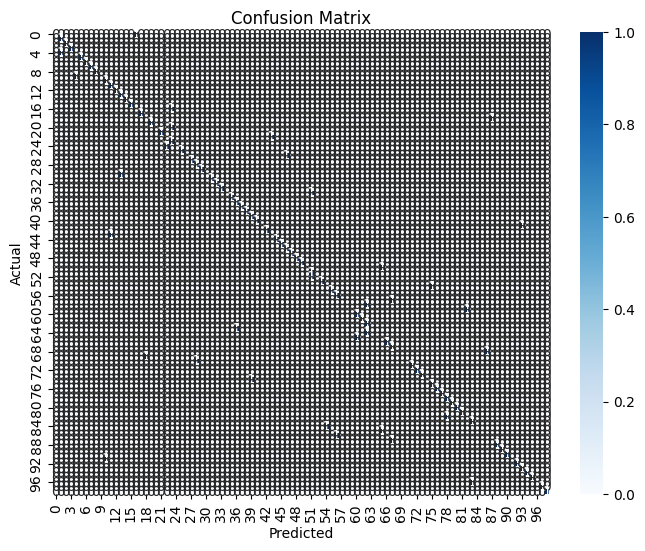

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have conf_matrix computed

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def visualize_layers(model, img):
    # Extract intermediate layer outputs
    layer_outputs = [layer.output for layer in model.layers]

    # Create a model that returns the layer outputs
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Get the activations for the input image
    activations = activation_model.predict(img.reshape(1, *img.shape))

    # Plot the activations
    layer_names = [layer.name for layer in model.layers]

    for layer_name, layer_activation in zip(layer_names, activations):
        if 'conv' in layer_name:
            # Plot only Convolutional layers
            plt.figure(figsize=(100, 100))
            for i in range(layer_activation.shape[3]):
                plt.subplot(1, layer_activation.shape[3], i + 1)
                plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
                plt.title(f'{layer_name} - Filter {i + 1}')
                plt.axis('off')
            plt.show()

1/1 [==============================] - 0s 114ms/step


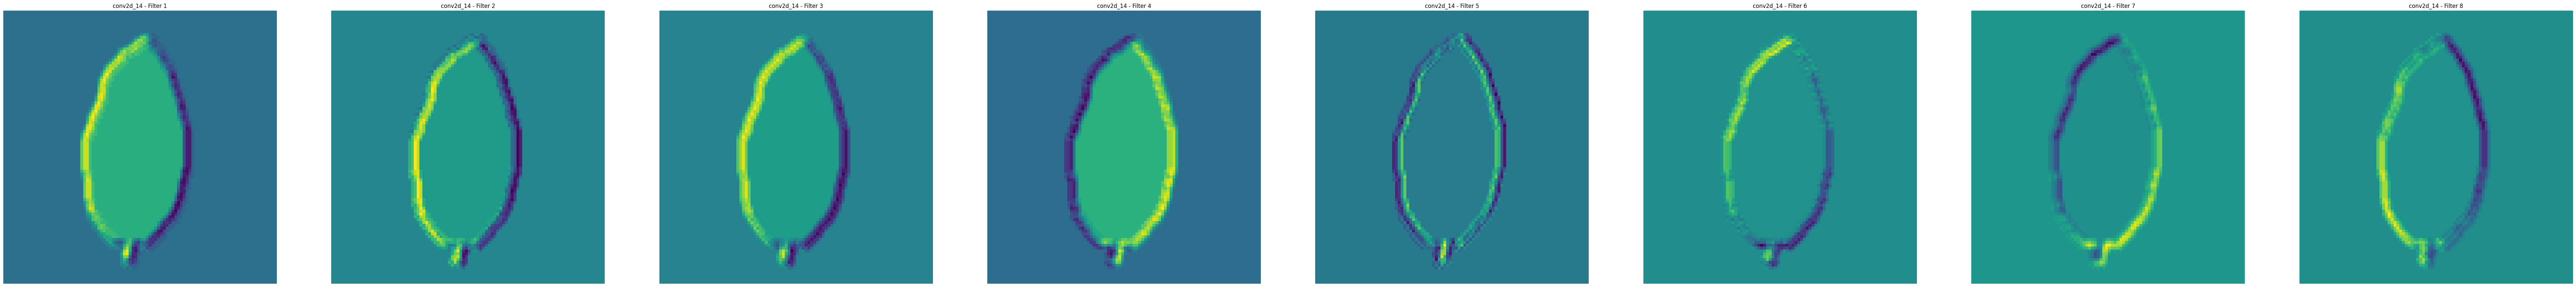

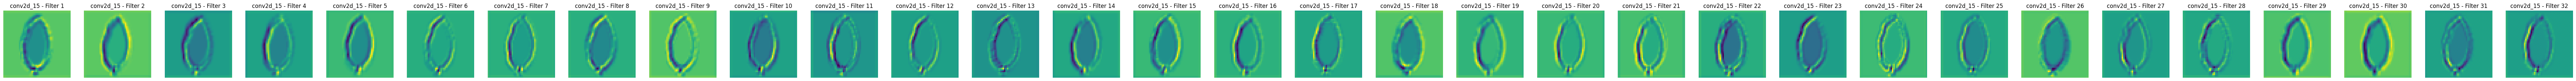

In [ ]:
visualize_layers(model, X_img_tr[0])

In [ ]:
for layer in model.layers:
    print(layer.name)

image
conv2d_14
activation_14
max_pooling2d_14
conv2d_15
activation_15
max_pooling2d_15
flatten_7
dense_14
dropout_7
dense_15


Filter Visualization

-Instead of displaying the activations, you can directly visualize the filters learned by the convolutional layers. This helps understand what patterns or features each filter is sensitive to.

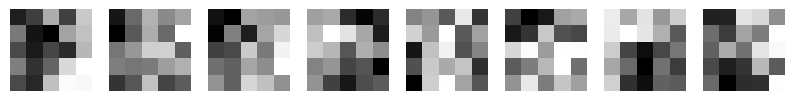

In [ ]:
def visualize_filters(model):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer_name = 'conv2d_14'  # Change this to your desired convolutional layer
    filter_weights = layer_dict[layer_name].get_weights()[0]
    plt.figure(figsize=(10, 10))
    for i in range(filter_weights.shape[3]):
        plt.subplot(8, 8, i+1)
        plt.imshow(filter_weights[:, :, 0, i], cmap='gray')
        plt.axis('off')
    plt.show()
visualize_filters(model)
